# Debugging Outputs

## Question 1
-  Please set the numpy random seed to 0 via `np.random.seed(0)`

- In each layer, please initialize your weights first and then the biases both in Numpy array form to get the exact same behavior here.
    - Initialized prediction: [0.64299999 0.79969983]
    - Error in nodes: [array([0.05582764, 0.57265422]), array([0.96370331, 0.64875612])] 
    - Prediction after fitting once: [0.63303039 0.78480164]

# Q1 NN template

In [555]:
import numpy as np
np.random.seed(0)

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return (1 - np.square(np.tanh(x)))

class NN():
    def __init__(self, architecture, learning_rate=0.01, activation=lambda x: x, activation_grad=lambda x: 1):
        '''This is a fully connected NN. The architecture is a list, 
        with each element specifying the number of nodes in each layer'''
        self.arch = architecture
        self.activation = activation
        self.activation_grad = activation_grad
        self.lr = learning_rate
        self.ffcount = len(self.arch) - 1 # number of feedforward step
        self.initialized=False        
        
    def init_weights(self):
        self.weights = []
        self.biases= []
        for n in range(1, self.ffcount + 1):
            # Start from n+1 because the first n is the input layer
            this_layer_weight = np.random.random([self.arch[n], self.arch[n-1]])
            self.weights.append(this_layer_weight)
            this_layer_bias = np.random.random(self.arch[n])
            self.biases.append(this_layer_bias)
        self.initialized = True

    def feed_forward(self, x):
        """
        Takes in an input layer x, and computes the corresponding weight * the input
        plus the bias for every input in x. In other words, take the dot product of
        the input layer with the weights layer, and add the bias.

        Feed the dot product into the activation function, and set that output as the new input
        """
        
        if self.initialized:
            input = x 
            self.activated_vectors = []
            self.weighted_inputs = []
            for n in range(self.ffcount):
                # calculate dot product of weights with x
                weighted_input = np.dot(self.weights[n], input) + self.biases[n]
                self.weighted_inputs.append(weighted_input)
                activated = self.activation(weighted_input)
                self.activated_vectors.append(activated)
                # print(f"n is: {n} and input is {input} and activated is {activated}")
                input = activated
            return input
        else:
            print("Please initialize the weights first!")  
            
    def calc_errors(self, y):
        # errors = []
        # for activated_vector, weighted_input in zip(self.activated_vectors, self.weighted_inputs):
        #     costs = (activated_vector - y) * self.activation_grad(weighted_input)
        #     errors.append(costs)
        # return errors

        output_error = (self.activated_vectors[-1] - y) * self.activation_grad(self.weighted_inputs[-1])
        self.errors = [output_error]
        
        for n in range(self.ffcount - 1):
            this_weighted_input = self.weighted_inputs[-2 - n]
            next_weights_transpose = np.transpose(self.weights[-1-n])
            delta_l = np.dot(next_weights_transpose, self.errors[n]) * self.activation_grad(this_weighted_input)
            self.errors.append(delta_l)

        self.errors.reverse()
        return self.errors
            
    
    def calc_grads(self):
        self.biases_grad = self.errors
        self.weights_grad = [np.zeros(weight.shape) for weight in self.weights]
        # for L in range(0, self.ffcount):
        #     self.weights_grad.append(np.dot(self.biases_grad[- 1 - L], np.transpose(self.activated_vectors[-2-L])))
        # return (self.biases_grad, self.weights_grad)

        for n in range(self.ffcount - 1, 0, -1):
                self.weights_grad[n] = np.dot(self.errors[n], np.transpose(self.activated_vectors[n - 1]))
    
        return self.biases_grad, self.weights_grad
        
    def back_prop(self):
        for n in range (self.ffcount - 1, 0, -1):
            self.weights[n] -= self.lr * self.weights_grad[n]
            self.biases[n] -= self.lr * self.biases_grad[n]
        
    def fit(self, x, y):
        self.feed_forward(x)
        self.calc_errors(y)
        self.calc_grads()
        self.back_prop()
        
    def predict(self,x):
        return self.feed_forward(x)
    
nn = NN([6,2,2],0.01,tanh,tanh_grad)


# 1a) and 1b)

In [556]:
nn.init_weights()
input = np.array([-1,1,-1,-1,1,-1])
nn.predict(input)

array([0.64299999, 0.79969983])

# 1c)

In [557]:
y = [-1, -1]
nn.calc_errors(y)

[array([0.05582764, 0.57265422]), array([0.96370331, 0.64875612])]

In [558]:
print(len(nn.activated_vectors))
print(len(nn.errors))
# print(nn.ffcount)
print(len(nn.weights))
print(len(nn.biases))
# nn.activated_vectors[-3]

2
2
2
2


In [559]:
nn.calc_grads()

([array([0.05582764, 0.57265422]), array([0.96370331, 0.64875612])],
 [array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  -0.35509187366406003])

In [560]:
nn.fit(input, y)

# 1d)

In [562]:
nn.predict(input)

array([0.6367329 , 0.79699359])

The weight update for the wij values is given by this formula:
$$ \text{New Weight} = \text{Old Weight} - \text{Learning Rate} * \delta ^ l * (a^{l-1})^T$$
where $\delta$ is the error, $l$ is the level (feed forward step), and $a$ is the output of the activation function. Note that $a$ needs to be the output of the activation of the previous level.

# Q2 simple perceptron + kfold templates

In [614]:
import pandas as pd
df = pd.read_csv('titanic.csv')

# data cleaning
df = df[["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Age", "Fare", 'Survived']].dropna()
df.head()

,Pclass,Sex,SibSp,Parch,Embarked,Age,Fare,Survived
0,3,male,1,0,S,22.0,7.2500,0
1,1,female,1,0,C,38.0,71.2833,1
2,3,female,0,0,S,26.0,7.9250,1
3,1,female,1,0,S,35.0,53.1000,1
4,3,male,0,0,S,35.0,8.0500,0


In [615]:
# Split into categorical and continuous features
categorical_features = df[['Pclass', 'Sex', 'Embarked', 'SibSp','Parch']] 
continuous_features = df[['Age','Fare']] 

In [616]:
from sklearn.preprocessing import OneHotEncoder

X_cate = categorical_features.values

print('All categories:\n')
for j in range(X_cate.shape[1]):
    print(np.unique(X_cate[:,j]))
    
encoder = OneHotEncoder()
encoder.fit(X_cate)
X_onehot = encoder.transform(X_cate).toarray()
print('shape of one hot encoded data',X_onehot.shape)
X_onehot

All categories:

[1 2 3]
['female' 'male']
['C' 'Q' 'S']
[0 1 2 3 4 5]
[0 1 2 3 4 5 6]
shape of one hot encoded data (712, 21)


array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [617]:
# Decode the onehot data
print(encoder.inverse_transform(X_onehot))
print()
print(X_cate)

[[3 'male' 'S' 1 0]
 [1 'female' 'C' 1 0]
 [3 'female' 'S' 0 0]
 ...
 [1 'female' 'S' 0 0]
 [1 'male' 'C' 0 0]
 [3 'male' 'Q' 0 0]]

[[3 'male' 'S' 1 0]
 [1 'female' 'C' 1 0]
 [3 'female' 'S' 0 0]
 ...
 [1 'female' 'S' 0 0]
 [1 'male' 'C' 0 0]
 [3 'male' 'Q' 0 0]]


In [618]:
survival_df = df['Survived']
survival = survival_df.values.reshape(-1, 1)
encoder = OneHotEncoder()
encoder.fit(survival)
survival_onehot = encoder.transform(survival).toarray()
print('shape of one hot encoded data',survival_onehot.shape)
survival_onehot

shape of one hot encoded data (712, 2)


array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [609]:
# print(encoder.inverse_transform(survival_onehot))
print();

In [842]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
import math

class simple_perceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.0001,activation=lambda x:x,activation_grad=lambda x:1):
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.activation=activation
        self.activation_grad=activation_grad
        self.lr=learning_rate
        ### initialize parameters ###
        self.weights=np.random.rand(output_dim, input_dim) * .05 
        self.biases=np.random.rand(output_dim) * .05

    def predict(self,X):
        if len(X.shape)==1:
            X=X.reshape((-1,1))
        dim=X.shape[1]
        # Check that the dimension of accepted input data is the same as expected
        if not dim==self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        ### Calculate logit and activation ###

        # My z and a code from above
        # weighted_input = np.dot(self.weights[n], input) + self.biases[n]
        # activated = self.activation(weighted_input)

        # print(X.shape)
        # print(self.weights.shape)
        self.z = (np.dot(self.weights, X.T) + self.biases).T             #shape(X.shape[0],1)
        # print(self.z.shape)
        self.a = self.activation(self.z)            #shape(X.shape[0],1)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape)==1:
            X=X.reshape((-1,1))
        if len(y.shape)==1:
            y=y.reshape((-1,1))
        self.predict(X)
        errors=(self.a-y)*self.activation_grad(self.z)
        print(self.a.shape)
        weights_grad=errors.T.dot(X)
        bias_grad=np.sum(errors,axis=0)
        ### Update weights and biases from the gradient ###
        self.weights -= self.lr * weights_grad
        self.biases -= self.lr * bias_grad

        
    def train_on_epoch(self,X,y,batch_size=32):
        # Every time select batch_size samples from the training set, until all data in the training set has been trained once
        order=list(range(X.shape[0]))
        random.shuffle(order)
        n=0
        while n<math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]],y[order[n*batch_size:(n+1)*batch_size]])
            n+=1
        # Parts that cannot fill one batch
        self.fit(X[order[n*batch_size:]],y[order[n*batch_size:]])
        
    def evaluate(self,X,y):
         # Transform the single-sample data into 2-dimensional
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        ### means square error ###
        return np.mean(np.square(self.predict(X) - y))
    
    def get_weights(self):
        return (self.weights,self.biases)
    
    def set_weights(self,weights):
        self.weights=weights[0]
        self.biases=weights[1]

In [849]:
from sklearn.model_selection import train_test_split,KFold


def Kfold(k,Xs,ys,epochs,learning_rate=0.0001,draw_curve=True):
    # The total number of examples for training the network
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs=Xs[train_selector]
        test_Xs=Xs[test_selector]
        train_ys=ys[train_selector]
        test_ys=ys[test_selector]

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys)
        
        ### Establish the model for simple perceptron here ###
        model=simple_perceptron(input_dim=train_in.shape[1], output_dim=1, learning_rate=learning_rate)
        
        # Save the lowest weights, so that we can recover the best model
        weights = model.get_weights()
        lowest_val_err = np.inf
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_on_epoch(train_in,train_real)
            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs    
        final_epochs=val_array.index(lowest_val_err)
        print("Number of epochs with lowest validation:",final_epochs)
        # Recover the model weight
        model.set_weights(weights)

        # Report result for this fold
        train_error= model.evaluate(train_Xs, train_ys)
        train_error_all.append(train_error)
        test_error= model.evaluate(testXs, test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model


In [850]:
survival_onehot.shape

(712, 2)

In [851]:
titanic_NN = Kfold(5, X_onehot, survival_onehot, 1000)

(32, 1)


ValueError: non-broadcastable output operand with shape (1,21) doesn't match the broadcast shape (2,21)

In [686]:
# A funtion that plots the correlation 
# between your prediction and the ground truth
def show_correlation(xs,ys):
    plt.figure()
    plt.scatter(xs,ys,s=0.5)
    r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
    plt.plot(r,r,'r')
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    corr=np.corrcoef([xs,ys])[1,0]
    print("Correlation coefficient:",corr)



In [687]:
Xs = X_onehot
ys = survival_onehot
total_num=len(Xs)
    
# Built in K-fold function in Sci-Kit Learn
kf=KFold(n_splits=5,shuffle=True)

for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs=Xs[train_selector]
        test_Xs=Xs[test_selector]
        train_ys=ys[train_selector]
        test_ys=ys[test_selector]

train_Xs.shape

(570, 21)

In [693]:
titanic_NN = Kfold(5, X_onehot, survival_onehot, 1000)

ValueError: non-broadcastable output operand with shape (1,21) doesn't match the broadcast shape (2,21)

# Q3

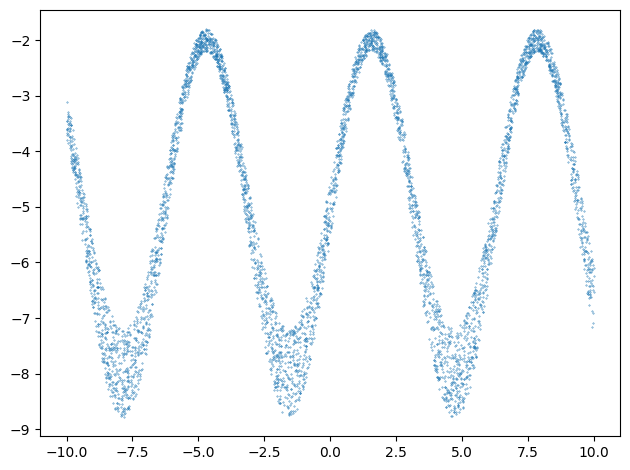

In [668]:
import numpy as np, matplotlib.pyplot as plt

def generate_X(number):
    xs=(np.random.random(number)*2-1)*10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs=generate_X(number)
    fs=3*np.sin(xs)-5
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return xs,fs*stochastic_ratio

x,y=generate_data(5000,0.1)
plt.scatter(x,y,s=0.1)
plt.tight_layout()

# 3a)

In [669]:
model = Kfold(k=5, Xs=x.reshape((-1, 1)), ys=y.reshape((-1,1)), epochs=50, learning_rate=0.001)

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (32,1)

Here we use the Multi-layer Perceptron regressor built-in from sklearn as a simple ANN <br>
[MLP regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [ ]:
from sklearn.neural_network import MLPRegressor

def KFold_NN(k,Xs,ys,hidden_layers,epochs=1000,lr=0.001,):
    # The total number of examples for training the network
    total_num=len(Xs)

    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_error_all=[]
    test_error_all=[]
    for train_selector,test_selector in kf.split(range(total_num)):
        # Decide training examples and testing examples for this fold
        ...
        
        # Establish the model here
        model = MLPRegressor(max_iter=epochs, activation='tanh', early_stopping=True, 
                             validation_fraction=0.25, learning_rate='constant', learning_rate_init=lr,
                             hidden_layer_sizes=hidden_layers).fit(train_Xs, train_ys)
        
        ### Report result for this fold ##
        train_error=...
        train_error_all.append(train_error)
        test_error=...
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)

    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model
